In [1]:
import numpy as np
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import clip
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR

In [2]:
# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Define transformations including data augmentation for training
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
])

# Transformations for validation and testing
val_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
])

# Custom dataset to load images and their text descriptions
class GarbageDataset(Dataset):
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        description = os.path.splitext(os.path.basename(image_path))[0]
        return image, description, label

# Function to load data
def load_data(base_path, dataset_type, groups):
    images, labels = [], []
    for idx, group in enumerate(groups):
        group_path = os.path.join(base_path, dataset_type, group)
        for file_name in os.listdir(group_path):
            image_path = os.path.join(group_path, file_name)
            if image_path.endswith(('.png', '.jpg', '.jpeg')):
                images.append(image_path)
                labels.append(idx)
    return images, labels

In [4]:
# Define paths and load datasets
base_path = 'C:/Users/vince/Downloads/garbage_data/'
groups = ["Blue", "TTR", "Green", "Black"]
train_images, train_labels = load_data(base_path, "CVPR_2024_dataset_Train", groups) 
val_images, val_labels = load_data(base_path, "CVPR_2024_dataset_Val", groups)
test_images, test_labels = load_data(base_path, "CVPR_2024_dataset_Test", groups)

# Prepare datasets
train_dataset = GarbageDataset(train_images, train_labels, train_transforms)
val_dataset = GarbageDataset(val_images, val_labels, val_transforms)
test_dataset = GarbageDataset(test_images, test_labels, val_transforms)

# The batch size is set to 64 and create dataloader for train, validation, and test
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
# Classifier model definition with dropout (0.5) and layer sizes:
# input -> 1024 -> 512 -> 128 -> output (number of classes)
class ClassifierNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ClassifierNN, self).__init__()
        self.fc1 = nn.Linear(input_dim * 2, 1024) # Input to first hidden layer
        self.fc2 = nn.Linear(1024, 512)  # First hidden layer to second hidden layer
        self.fc3 = nn.Linear(512, 128)  # Second hidden layer to third hidden layer
        self.fc4 = nn.Linear(128, num_classes)  # Third hidden layer to output layer
        self.dropout = nn.Dropout(0.5) # Dropout layer with 0.5 probability

    def forward(self, image_features, text_features):
        
        # Concatenate image and text features along the feature dimension
        x = torch.cat([image_features, text_features], dim=1)     
        
        # First layer: Fully connected with ReLU activation and dropout
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        
        # Second layer: Fully connected with ReLU activation and dropout
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)

        # Third layer: Fully connected with ReLU activation
        x = torch.relu(self.fc3(x))
        
        # Output layer: Fully connected layer (no activation, raw scores for each class)
        x = self.fc4(x)
        return x


# Initialize classifier and other parameters
num_classes = len(groups)
classifier = ClassifierNN(512, num_classes).to(device)   # CLIP outputs 512-dim features for each image and text
# Define loss function 
criterion = nn.CrossEntropyLoss()


# Freeze all layers in the CLIP model
for param in model.parameters():
    param.requires_grad = False  

# Unfreeze only the last transformer block for fine-tuning
for param in model.visual.transformer.resblocks[-1].parameters():
    param.requires_grad = True

# Define an AdamW optimizer with two distinct learning rates
# - classifier.parameters() will use lr=0.001
# - the last transformer block's parameters will use a smaller learning rate of lr=1e-7
optimizer = torch.optim.AdamW([
    {'params': classifier.parameters(), 'lr': 0.001},
    {'params': model.visual.transformer.resblocks[-1].parameters(), 'lr': 1e-6}
])

# Define learning rate scheduler for the optimizer
scheduler = StepLR(optimizer, step_size=2, gamma=0.7)

In [11]:
# Training loop with early stopping and saving the best model
def train_model(model, classifier, train_loader, val_loader, num_epochs=20, save_path="best_model.pth"):
    best_val_loss = float('inf') # Initialize best validation loss
    early_stopping_counter = 0 # Initialize early stopping counter
    early_stopping_patience = 5
    
    for epoch in range(num_epochs):
        model.eval() # CLIP model is pre-trained, so we freeze it except for the fine-tuned layer
        classifier.train()  # Train classifier only

        
        # Track training loss and accuracy
        total_train_loss = 0
        correct_train, total_train = 0, 0
        
        # Training step
        for images, descriptions, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            tokenized_texts = clip.tokenize(descriptions).to(device)
            with torch.no_grad():
                # Extract features using CLIP model
                image_features = model.encode_image(images).float() # Ensure features are float32
                text_features = model.encode_text(tokenized_texts).float()

            optimizer.zero_grad()
            outputs = classifier(image_features, text_features) # Pass both features
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step() # First, call optimizer.step() to update model parameters
            # Track training loss and accuracy
            total_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate average training loss and accuracy for the epoch
        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train



        
        scheduler.step() # Adjust learning rate each epoch
 
        


        # Validation step with accuracy and loss tracking
        val_loss, val_accuracy = validate_model(classifier, val_loader) # Get validation loss and accuracy

        
        # Print loss and accuracy for each epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        
        
        # Early stopping and model saving logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0 # Reset early stopping counter
            # Save the model
            torch.save(classifier.state_dict(), save_path) # Save model before stopping
            print(f"Epoch {epoch+1}: Validation loss improved, saving model to {save_path}.")
        else:
            early_stopping_counter += 1
            # Check for early stopping
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping triggered.") 
                break

        


# Validation function to calculate loss and accuracy
def validate_model(classifier, val_loader):
    classifier.eval()
    total_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for images, descriptions, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            tokenized_texts = clip.tokenize(descriptions).to(device)
            # Extract features
            image_features = model.encode_image(images).float()
            text_features = model.encode_text(tokenized_texts).float()
            # Forward pass
            outputs = classifier(image_features, text_features)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(val_loader)
    return avg_loss, accuracy    



# Testing function to evaluate on the test set
def test_model(classifier, test_loader):
    classifier.eval()
    all_preds, all_labels = [], []
    correct, total = 0, 0
    with torch.no_grad():
        for images, descriptions, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            tokenized_texts = clip.tokenize(descriptions).to(device)
            # Extract features
            image_features = model.encode_image(images).float()
            text_features = model.encode_text(tokenized_texts).float()
            # Forward pass
            outputs = classifier(image_features, text_features)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # Store predictions and labels
            all_preds.extend(predicted.cpu().numpy()) # Move to CPU and store
            all_labels.extend(labels.cpu().numpy()) # Move to CPU and store

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy}%')
    return np.array(all_preds), np.array(all_labels)  

In [13]:
# Call the training function
train_model(model, classifier, train_loader, val_loader, num_epochs=20, save_path="best_model.pth")

Epoch [1/20], Train Loss: 0.5095, Train Accuracy: 79.89%, Val Loss: 0.3256, Val Accuracy: 88.22%
Epoch 1: Validation loss improved, saving model to best_model.pth.
Epoch [2/20], Train Loss: 0.3204, Train Accuracy: 88.54%, Val Loss: 0.2942, Val Accuracy: 89.17%
Epoch 2: Validation loss improved, saving model to best_model.pth.
Epoch [3/20], Train Loss: 0.2557, Train Accuracy: 90.70%, Val Loss: 0.2595, Val Accuracy: 90.89%
Epoch 3: Validation loss improved, saving model to best_model.pth.
Epoch [4/20], Train Loss: 0.2343, Train Accuracy: 91.50%, Val Loss: 0.2604, Val Accuracy: 90.78%
Epoch [5/20], Train Loss: 0.2015, Train Accuracy: 92.44%, Val Loss: 0.2536, Val Accuracy: 90.78%
Epoch 5: Validation loss improved, saving model to best_model.pth.
Epoch [6/20], Train Loss: 0.1917, Train Accuracy: 93.16%, Val Loss: 0.2464, Val Accuracy: 91.11%
Epoch 6: Validation loss improved, saving model to best_model.pth.
Epoch [7/20], Train Loss: 0.1590, Train Accuracy: 94.06%, Val Loss: 0.2566, Val Acc

Test Accuracy: 84.69833867677062%


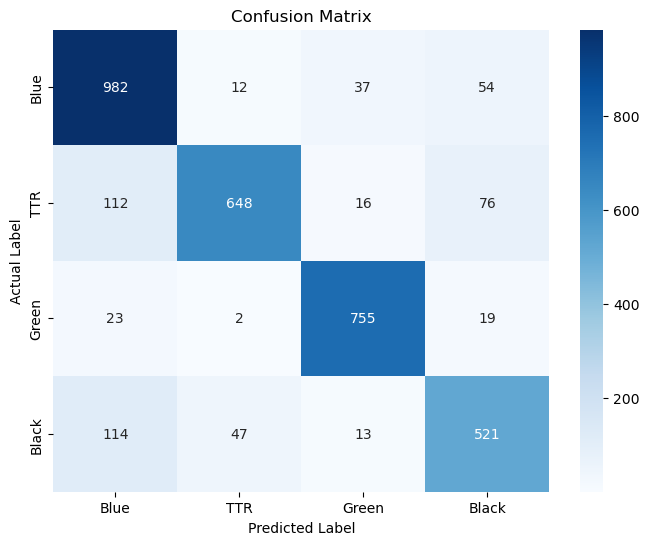

              precision    recall  f1-score   support

        Blue       0.80      0.91      0.85      1085
         TTR       0.91      0.76      0.83       852
       Green       0.92      0.94      0.93       799
       Black       0.78      0.75      0.76       695

    accuracy                           0.85      3431
   macro avg       0.85      0.84      0.84      3431
weighted avg       0.85      0.85      0.85      3431



In [15]:
# Test the trained model and get predictions and labels on the test set
all_preds, all_labels = test_model(classifier, test_loader)

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(all_labels, all_preds)
# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=groups, yticklabels=groups)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()
# Classification Report
print(classification_report(all_labels, all_preds, target_names=groups))